This notebook analyses the priors used directly by sampling from the LME models

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
import math
import patsy
import arviz as az

import pystan
import stan_utility

/home/gabriel/anaconda3/envs/pystan/lib/python3.7/site-packages/xarray/core/merge.py:18: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)
/home/gabriel/anaconda3/envs/pystan/lib/python3.7/site-packages/xarray/core/dataarray.py:1829: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  'DataArray', pd.Series, pd.DataFrame, pd.Panel]:


## LMMs on chronometric data

## Prior extracted from the stan code

In [2]:
priors_LME = stan_utility.compile_model('LME_prior_only.stan', path="", model_name="LMEprior")

Using cached StanModel


In [3]:
LMEdata = pd.read_csv('LMEdata.csv')
LMEdata = LMEdata[LMEdata.exp == 1]

fixeff_form = "1+SAT+contrast+response+givenResp+SAT:contrast+SAT:response+contrast:response+SAT:contrast:response"#Fixed effects formula
raneff_form = fixeff_form #Random effects formula
fixeff = np.asarray(patsy.dmatrix(fixeff_form, LMEdata)) #FE design matrix
raneff = np.asarray(patsy.dmatrix(raneff_form, LMEdata)) #RE design matrix
prior_intercept = np.asarray([6.15,.3])#prior for intercept, mu and sigma
priors_mu = np.repeat(0, 8) #Priors on mu for FE
priors_sigma =  np.repeat(.4, 8) # priors on sigma for FE
priors_raneff = [0, .4] #Priors on RE
prior_sd = [0, .4] #priors on residual sigma

RT_LME_data = dict(
    N = len(LMEdata),
    P = fixeff.shape[-1], #number of pop level effects
    J = len(LMEdata.participant.unique()),
    n_u = raneff.shape[-1],
    subj = LMEdata.participant,
    X = fixeff,
    Z_u = raneff,
    y = LMEdata.logrt.get_values(),
    p_intercept = prior_intercept, p_sd = prior_sd, p_fmu = priors_mu, p_fsigma = priors_sigma, p_r = priors_raneff,
    logT = 1
)

RT_fit = priors_LME.sampling(data=RT_LME_data, iter=2000, chains=6, n_jobs=6, 
                      warmup =1000)


/home/gabriel/anaconda3/envs/pystan/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
/home/gabriel/anaconda3/envs/pystan/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


### On the log scale

/home/gabriel/anaconda3/envs/pystan/lib/python3.7/site-packages/arviz/plots/forestplot.py:207: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/home/gabriel/anaconda3/envs/pystan/lib/python3.7/site-packages/arviz/plots/forestplot.py:208: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


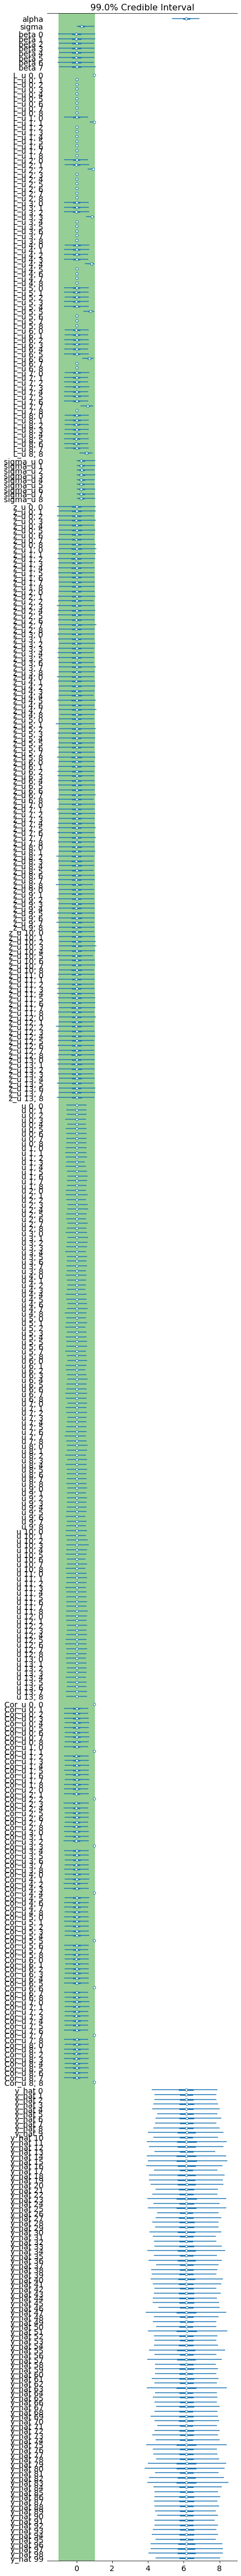

In [4]:
g = az.plot_forest(RT_fit, var_names=["~raw_beta","~raw_intercept"], credible_interval=0.99, 
                   combined=True, rope=[-1,1])
plt.show()


### On the natural scale

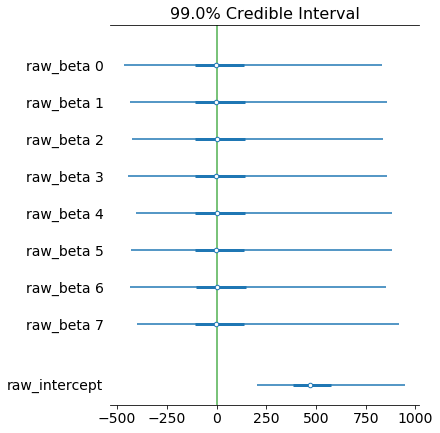

In [5]:
g = az.plot_forest(RT_fit, var_names=["raw_beta","raw_intercept"], credible_interval=0.99, 
                   combined=True, rope=[-1,1])
plt.show()


### Data congruent with the priors

In [16]:
pred_rt = RT_fit.extract("y_hat")
pred_rt = np.asarray(pred_rt['y_hat'])
pred_rt = pred_rt.flatten()
sample = np.random.choice(pred_rt, size=1000, replace=False)

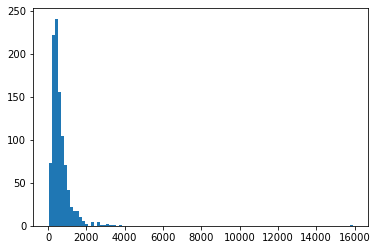

In [19]:
g = plt.hist([np.exp(x) for x in sample], bins=100)